In [2]:
%%capture
!pip install rasterio contextily

In [ ]:
!pip install tensorflow==2.7

In [ ]:
!pip3 install tensorflow==2.2
!pip3 install keras==2.3.1
!pip3 install -U segmentation-models


%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
tf.keras.backend.set_image_data_format('channels_last')

In [39]:
import numpy as np
import pandas as pd
import cv2
import os
import zipfile
import rasterio
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Activation, Conv2DTranspose
from tensorflow.keras.optimizers import Adam 
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy, Precision, Recall, MeanIoU, binary_accuracy
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# U-Net

In [23]:
def unet(input_size=(1024, 1024, 3)):
    inputs = keras.layers.Input(input_size)

    # Contracting path

    c1 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(inputs)
    c1 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(p1)
    c2 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(p2)
    c3 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c3)

    # Expansive path

    u4 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = keras.layers.concatenate([u4, c2])
    c4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(u4)
    c4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c4)

    u5 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = keras.layers.concatenate([u5, c1])
    c5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(u5)
    c5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01))(c5)

    outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [40]:
# Optimizer Adam with learning rate 0.0001
optim = keras.optimizers.Adam(0.0001)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# Dice loss and focal loss are good when we have class imbalance 
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.BinaryFocalLoss() 
total_loss = dice_loss + (1 * focal_loss)

# Metrics: intersection over union (IOU), F1 score
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

keras.utils.set_random_seed(42)
model = unet()
model.compile(optimizer=optim, 
            loss=total_loss, 
            metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)],)

# Data import

In [11]:
!wget --no-check-certificate \
    "https://github.com/Chiffaa/Glacier-lakes-detection-using-multi-resolution-input-channels/archive/refs/heads/in-progress.zip" \
    -O "/tmp/lakes.zip"


zip_ref = zipfile.ZipFile('/tmp/lakes.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-03-20 18:46:23--  https://github.com/Chiffaa/Glacier-lakes-detection-using-multi-resolution-input-channels/archive/refs/heads/in-progress.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Chiffaa/Glacier-lakes-detection-using-multi-resolution-input-channels/zip/refs/heads/in-progress [following]
--2023-03-20 18:46:23--  https://codeload.github.com/Chiffaa/Glacier-lakes-detection-using-multi-resolution-input-channels/zip/refs/heads/in-progress
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/lakes.zip’

/tmp/lakes.zip          [       <=>          ]   1.01G   276KB/s    in 92s     

2023-03-20 18:47:55 (11.2

In [45]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def crop_patches(X, y, size=256):
    X_patches = []
    y_patches = []
    
    im_size = X.shape[1]

    if im_size < size: 
         print("The image is smaller than the size of a patch")

    for i in range(len(X)):
        for j in range(0, im_size-size+1, size):
            for k in range(0, im_size-size+1, size):
                patch_X = np.array(X[i])[j:j+size, k:k+size, :]
                patch_y = np.array(y[i])[j:j+size, k:k+size]
                if np.sum(patch_y) > 0:
                    X_patches.append(patch_X)
                    y_patches.append(patch_y)
    
    return np.array(X_patches), np.array(y_patches)


def im_import(path_to_images, path_to_labels, path='/tmp/Glacier-lakes-detection-using-multi-resolution-input-channels-in-progress/train_test_data'):
        X = [] # images
        y = [] # labels 
        for image_name in os.listdir(path + path_to_images):
            # Importing the data 
            img = cv2.imread(path + path_to_images + image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(normalize(img))
            lbl = rasterio.open(path + path_to_labels + image_name + 'f')
            #lbl = cv2.cvtColor(lbl, cv2.COLOR_BGR2RGB)
            y.append(((lbl.read(1) > 0.5).astype(int)).astype(float))
    
        X = np.array(X)
        y = np.array(y)
        return X, y

In [46]:
X, y = im_import('/images/', '/labels/')

<ipython-input-45-a2ccfefb24ea>:4: RuntimeWarning: invalid value encountered in true_divide
  return ((array - array_min)/(array_max - array_min))


In [47]:
X.shape

(360, 1024, 1024, 3)

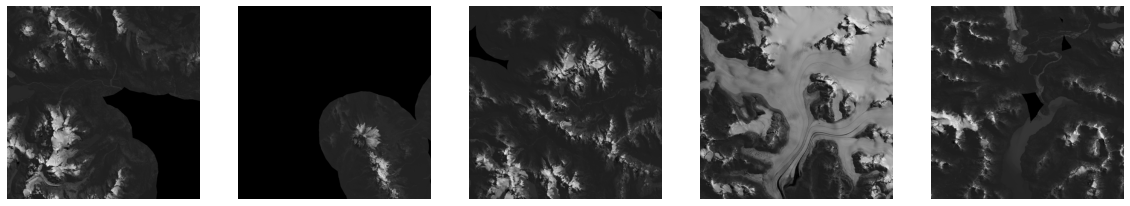

In [11]:
plt.figure(figsize=(20, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(X[15+i])
    plt.axis("off")

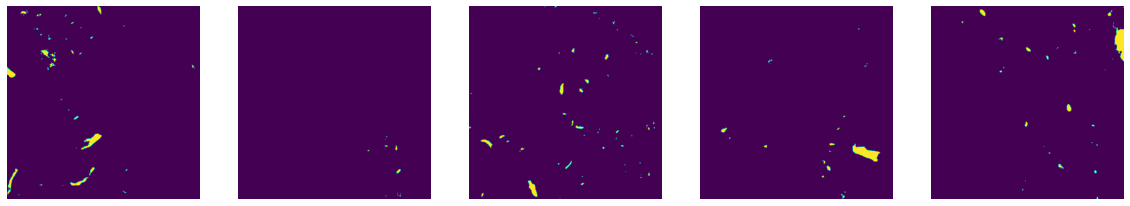

In [12]:
plt.figure(figsize=(20, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(y[15+i])
    plt.axis("off")

# Training and testing

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(288, 1024, 1024, 3)

In [19]:
y_train.shape

(288, 1024, 1024)

In [50]:
tf.config.run_functions_eagerly(True)

In [ ]:
history = model.fit(
   x=X_train,
   y=y_train,
   batch_size=1,
   epochs=10,
   validation_split=0.2,
)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
230/230 [==============================] - 63s 263ms/step - loss: nan - iou_score: 3.0133e-07 - f1-score: 3.0133e-07 - val_loss: nan - val_iou_score: 2.0525e-07 - val_f1-score: 2.0525e-07
Epoch 2/10
230/230 [==============================] - 59s 259ms/step - loss: nan - iou_score: 3.0137e-07 - f1-score: 3.0137e-07 - val_loss: nan - val_iou_score: 2.0525e-07 - val_f1-score: 2.0525e-07
Epoch 3/10
134/230 [================>.............] - ETA: 22s - loss: nan - iou_score: 3.1306e-07 - f1-score: 3.1306e-07